In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 + 3 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 1000 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [6]:
t_interval = 0.001
t_len = int((15-10) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [136]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [137]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = [cm_target[-4],] + cm_target[:-4] + cm_target[-3:]

In [138]:
cm_target

['NACA0018cm_blade1.csv',
 'case1cm_blade1.csv',
 'case2cm_blade1.csv',
 'case4cm_blade1.csv',
 'case5cm_blade1.csv',
 'case7cm_blade1.csv',
 'case8cm_blade1.csv',
 'case13cm_blade1.csv',
 'case14cm_blade1.csv',
 'case15cm_blade1.csv',
 'case16cm_blade1.csv',
 'case17cm_blade1.csv',
 'case18cm_blade1.csv',
 'case19cm_blade1.csv',
 'case20cm_blade1.csv',
 'case21cm_blade1.csv']

In [10]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
#     hh = generate_h(n_beta, t_len, normalize)
#     bb = generate_beta(n_beta, t_len, normalize)
#     total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    #x = np.hstack((t, hh, bb, total_coords))
    #x = np.hstack((t, total_coords))
    x = t
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x: ", x.shape)
    print("Dimension - y: ", y.shape)
    
    return x, y, t, cm

In [157]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=10, time<15))]
        cm_beUsed = cm[np.where(np.logical_and(time>=10, time<15))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
#         time_beUsed = handler_time(time_beUsed)
#         cm_beUsed = handler_cm(cm_beUsed)
        
#         linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
#                                            bounds_error=False,kind='quadratic',
#                                            fill_value='extrapolate')
#         time_interp = np.arange(10, 15, t_interval).reshape((-1,1))
#         cm_interp=linear_func(time_interp).reshape((-1,1))
        time_interp = time_beUsed.reshape((-1,1))
        cm_interp = cm_beUsed.reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
        
        plt.plot(time_interp, cm_interp)
        plt.grid()
        plt.title('case '+str(case_number[i]))
        plt.ylim([-0.05, 0.22])
        plt.show()
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [12]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [109]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [112]:
# Handling outlier, (if there are)
# New version
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for ix, cmValue in enumerate(cm_beUsed):
        if cmValue >= 0.21 or cmValue < -0.05:
            cm_beUsed[ix] = (cm_beUsed[ix-period] + cm_beUsed[ix+period])/ 2
            
    return cm_beUsed

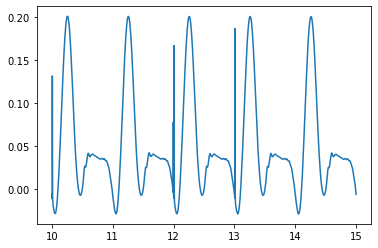

In [114]:
plt.plot(t[:5000], case7_ad)

In [14]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

    beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [15]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [16]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    
    baseline_coord_high = data.iloc[0,:]
    baseline_coord_low = data.iloc[1,:]
    baseline_coord = np.hstack((np.flip(baseline_coord_high), baseline_coord_low)).reshape((1,-1))
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    total_coords = np.hstack((airfoil_coord, flap_coords))
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [17]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,5))
    flap_right = np.zeros((15,5))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
        xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((5,1))

        for j in range(n_beta):
            betaValue = beta[j]

            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords2 = np.zeros((n_cases, 10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [18]:
# Generating x, y and cm (for denormalizing)
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (80000, 2)
Dimension - x:  (80000, 1)
Dimension - y:  (80000, 1)


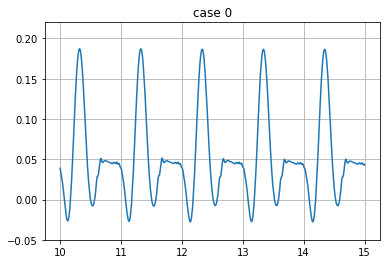

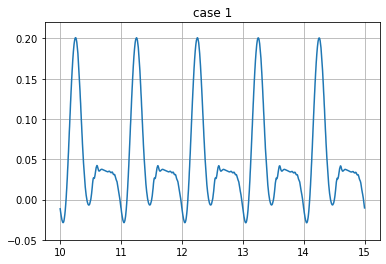

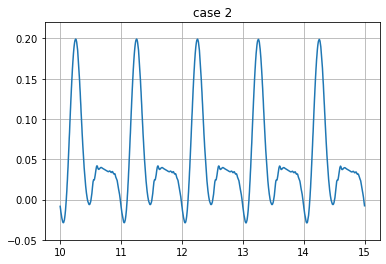

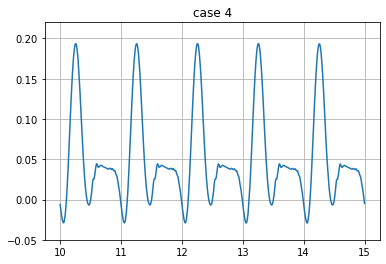

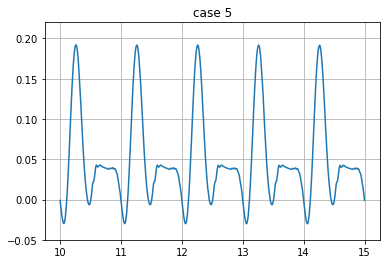

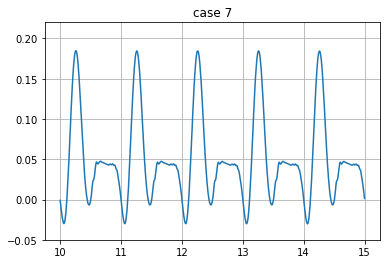

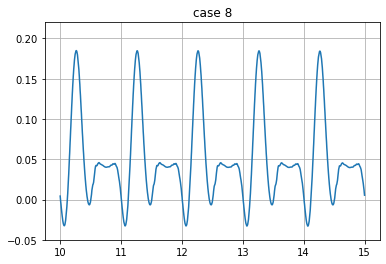

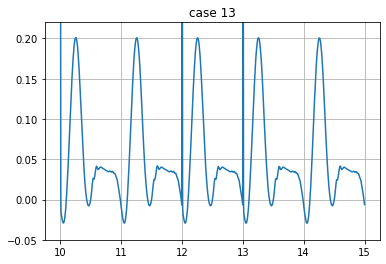

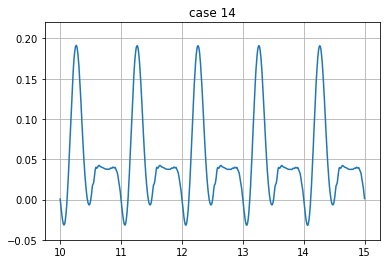

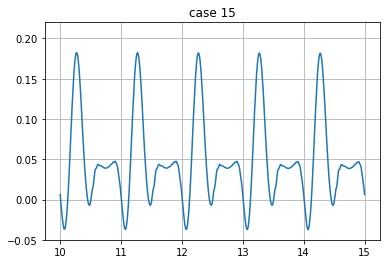

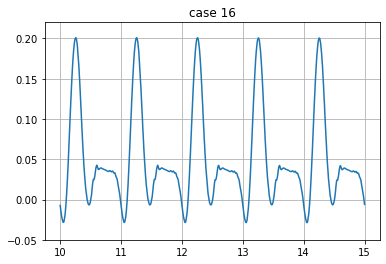

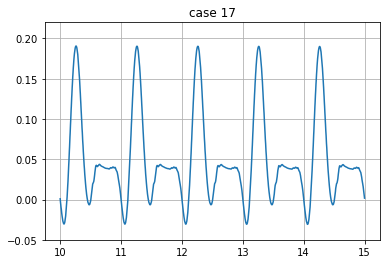

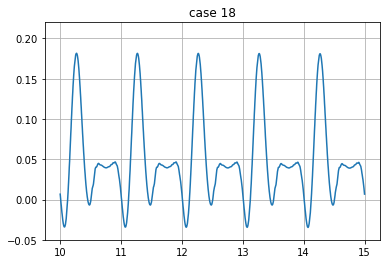

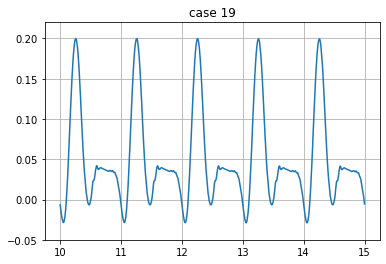

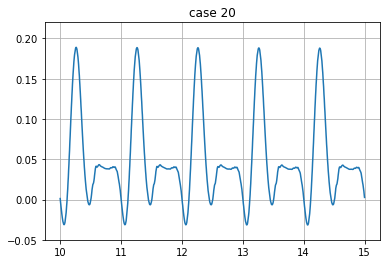

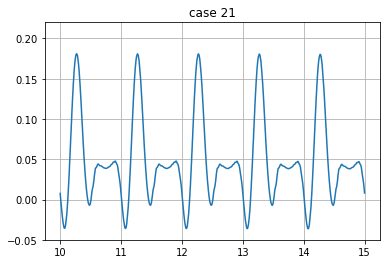

Dimension - time and Cm:  (62331, 2)
Dimension - x:  (62331, 1)
Dimension - y:  (62331, 1)


In [158]:
x, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

In [152]:
case_number = [0,1,2,4,5,7,8,13,14,15,16,17,18,19,20,21]

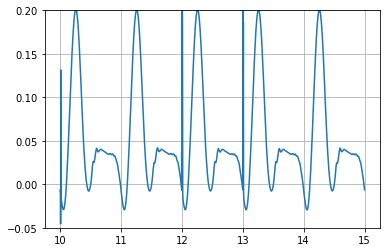

In [129]:
case7 = cm[5000*7:5000*8]
plt.plot(t[:5000], case7)
plt.grid()
plt.ylim([-0.05, 0.2])
plt.show()

In [19]:
x -=10

In [20]:
def dataset_split(x, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_all, x_test, y_all, y_test, cm_all, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_train, x_val, y_train, y_val, cm_train, cm_val = train_test_split(x_all, y_all, cm_all, test_size=val_rate/(1-test_rate),
                                                                            random_state=kwargs.get('random_state'))
        return x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_train, x_test, y_train, y_test, cm_train, cm_test = train_test_split(x, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_train, x_test, y_train, y_test, cm_train, cm_test

In [21]:
x_train, x_val, x_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x, y, cm,
                                                                                          test_rate, val_rate=val_rate,
                                                                                          validation=True, random_state=50)

In [22]:
def make_mlp_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_data = tf.keras.Input(shape=1)

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                #kernel_initializer='he_uniform',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(input_data)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     #kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       #kernel_initializer='he_uniform',
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model(input_data, output_data)
    
    return model

In [23]:
model = make_mlp_model(num_layer=n_layers)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 fc1 (Dense)                 (None, 256)               512       
                                                                 
 fc2 (Dense)                 (None, 256)               65792     
                                                                 
 fc3 (Dense)                 (None, 256)               65792     
                                                                 
 fc4 (Dense)                 (None, 256)               65792     
                                                                 
 fc5 (Dense)                 (None, 256)               65792     
                                                                 
 outputLayer (Dense)         (None, 1)                 257   

In [24]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [25]:
model_directory = "D:\\TrainedModels\\20221227_flap1_2_randomState50"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [26]:
ckpt_name = model_directory + "20221227unsteadyPrediction_MLP_flap1_2_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_layers)+"layers_"+ str(n_units) +"units_randomState50_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=500, min_delta=1e-07,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, factor=0.5,
                                          min_delta = 1e-8, min_lr=1e-06, verbose=1)

In [27]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [28]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=[x_val, y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.3418e-04 - rmse: 0.0152
Epoch 1: val_loss improved from inf to 0.00011, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 2s 9ms/step - loss: 3.1400e-04 - rmse: 0.0145 - val_loss: 1.0976e-04 - val_rmse: 0.0027 - lr: 1.0000e-04
Epoch 2/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.3159e-04 - rmse: 0.0054
Epoch 2: val_loss improved from 0.00011 to 0.00011, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 6ms/step - loss: 1.2894e-04 - rmse: 0.0052 - val_loss: 1.0659e-04 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 3/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.0969e-04 - rmse

Epoch 19/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.1615e-04 - rmse: 0.0053
Epoch 19: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.1459e-04 - rmse: 0.0052 - val_loss: 9.1602e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 20/10000
54/55 [============================>.] - ETA: 0s - loss: 1.1192e-04 - rmse: 0.0050
Epoch 20: val_loss improved from 0.00009 to 0.00009, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 9ms/step - loss: 1.1148e-04 - rmse: 0.0050 - val_loss: 9.0567e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 21/10000
54/55 [============================>.] - ETA: 0s - loss: 9.5225e-

Epoch 37/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.0058e-04 - rmse: 0.0055
Epoch 37: val_loss improved from 0.00008 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.8978e-05 - rmse: 0.0053 - val_loss: 7.4941e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 38/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.1454e-04 - rmse: 0.0067
Epoch 38: val_loss improved from 0.00007 to 0.00007, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.1293e-04 - rmse: 0.0066 - val_loss: 7.4405e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 39/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.7274e-

55/55 [==============================] - 0s 9ms/step - loss: 8.3219e-05 - rmse: 0.0052 - val_loss: 6.0826e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 57/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.5753e-05 - rmse: 0.0055
Epoch 57: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.2566e-05 - rmse: 0.0052 - val_loss: 6.0552e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 58/10000
50/55 [==========================>...] - ETA: 0s - loss: 8.4773e-05 - rmse: 0.0054
Epoch 58: val_loss improved from 0.00006 to 0.00006, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.2301e-05 - rmse: 

55/55 [==============================] - 0s 7ms/step - loss: 9.1656e-05 - rmse: 0.0067 - val_loss: 5.2206e-05 - val_rmse: 0.0025 - lr: 1.0000e-04
Epoch 76/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.7884e-05 - rmse: 0.0047
Epoch 76: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.7081e-05 - rmse: 0.0046 - val_loss: 5.0183e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 77/10000
55/55 [==============================] - ETA: 0s - loss: 5.8024e-05 - rmse: 0.0036
Epoch 77: val_loss improved from 0.00005 to 0.00005, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.8024e-05 - rmse: 

Epoch 94/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.3384e-05 - rmse: 0.0067
Epoch 94: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.1804e-05 - rmse: 0.0066 - val_loss: 4.2819e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 95/10000
53/55 [===========================>..] - ETA: 0s - loss: 6.5476e-05 - rmse: 0.0052
Epoch 95: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 7ms/step - loss: 6.5659e-05 - rmse: 0.0053 - val_loss: 4.3440e-05 - val_rmse: 0.0024 - lr: 1.0000e-04
Epoch 96/10000
52/55 [===========================>..] - ETA: 0s - loss: 6.5326e-05 - rmse: 0.0053
Epoch 96: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_fla

49/55 [=========================>....] - ETA: 0s - loss: 5.5927e-05 - rmse: 0.0048
Epoch 113: val_loss did not improve from 0.00004
55/55 [==============================] - 0s 8ms/step - loss: 5.3476e-05 - rmse: 0.0046 - val_loss: 3.7409e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 114/10000
51/55 [==========================>...] - ETA: 0s - loss: 6.0847e-05 - rmse: 0.0053
Epoch 114: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 6.4506e-05 - rmse: 0.0057 - val_loss: 3.6952e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 115/10000
52/55 [===========================>..] - ETA: 0s - loss: 5.9374e-05 - rmse: 0.0052
Epoch 115: val_loss improved from 0.00004 to 0.00004, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0

Epoch 132/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.7386e-05 - rmse: 0.0054
Epoch 132: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.4813e-05 - rmse: 0.0052 - val_loss: 3.2661e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 133/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0467e-05 - rmse: 0.0016
Epoch 133: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.0360e-05 - rmse: 0.0015 - val_loss: 3.2430e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 134/10000
50/55 [==========================>...] - ETA: 0s - loss: 5.6

Epoch 150/10000
54/55 [============================>.] - ETA: 0s - loss: 5.0318e-05 - rmse: 0.0050
Epoch 150: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.9868e-05 - rmse: 0.0050 - val_loss: 2.9418e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 151/10000
54/55 [============================>.] - ETA: 0s - loss: 6.4410e-05 - rmse: 0.0063
Epoch 151: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 6.3706e-05 - rmse: 0.0062 - val_loss: 2.9316e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 152/10000
54/55 [============================>.] - ETA: 0s - loss: 5.7

55/55 [==============================] - 0s 8ms/step - loss: 4.8267e-05 - rmse: 0.0051 - val_loss: 2.6260e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 172/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.7958e-05 - rmse: 0.0051
Epoch 172: val_loss did not improve from 0.00003
55/55 [==============================] - 0s 7ms/step - loss: 4.7028e-05 - rmse: 0.0050 - val_loss: 2.6696e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 173/10000
55/55 [==============================] - ETA: 0s - loss: 4.9245e-05 - rmse: 0.0053
Epoch 173: val_loss improved from 0.00003 to 0.00003, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.9245e-05 - rmse: 0.0053 - val_loss: 2.5988e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 174/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.9413e-05 - rmse: 0.0053

55/55 [==============================] - 0s 9ms/step - loss: 3.8786e-05 - rmse: 0.0044 - val_loss: 2.3736e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 192/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.6642e-05 - rmse: 0.0061
Epoch 192: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 5.2623e-05 - rmse: 0.0058 - val_loss: 2.3759e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 193/10000
50/55 [==========================>...] - ETA: 0s - loss: 4.7410e-05 - rmse: 0.0053
Epoch 193: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.5391e-05 - rmse: 0.0051 - val_loss: 2.3532e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 194/10000
50/55 [==========================>...] - ETA: 0s - loss: 6.7353e-05 - rmse: 0.0070

Epoch 213/10000
51/55 [==========================>...] - ETA: 0s - loss: 4.5513e-05 - rmse: 0.0054
Epoch 213: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.3496e-05 - rmse: 0.0052 - val_loss: 2.1250e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 214/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.6245e-05 - rmse: 0.0054
Epoch 214: val_loss did not improve from 0.00002
55/55 [==============================] - 0s 8ms/step - loss: 4.8769e-05 - rmse: 0.0057 - val_loss: 2.1339e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 215/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.8524e-05 - rmse: 0.0047
Epoch 215: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_M

Epoch 233/10000
53/55 [===========================>..] - ETA: 0s - loss: 5.9798e-05 - rmse: 0.0067
Epoch 233: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 5.8179e-05 - rmse: 0.0066 - val_loss: 1.9216e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 234/10000
54/55 [============================>.] - ETA: 0s - loss: 3.6762e-05 - rmse: 0.0047
Epoch 234: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.6371e-05 - rmse: 0.0047 - val_loss: 1.9133e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 235/10000
49/55 [=========================>....] - ETA: 0s - loss: 5.0

Epoch 252/10000
54/55 [============================>.] - ETA: 0s - loss: 4.1236e-05 - rmse: 0.0053
Epoch 252: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.0734e-05 - rmse: 0.0053 - val_loss: 1.7396e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 253/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.0155e-05 - rmse: 0.0052
Epoch 253: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.9181e-05 - rmse: 0.0051 - val_loss: 1.7251e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 254/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4

Epoch 270/10000
49/55 [=========================>....] - ETA: 0s - loss: 4.0104e-05 - rmse: 0.0054
Epoch 270: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 4.2687e-05 - rmse: 0.0056 - val_loss: 1.5652e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 271/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.2549e-05 - rmse: 0.0046
Epoch 271: val_loss improved from 0.00002 to 0.00002, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.1787e-05 - rmse: 0.0045 - val_loss: 1.5555e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 272/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.8

51/55 [==========================>...] - ETA: 0s - loss: 5.7425e-05 - rmse: 0.0069
Epoch 289: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 5.9685e-05 - rmse: 0.0071 - val_loss: 1.3946e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 290/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.7802e-05 - rmse: 0.0053
Epoch 290: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.5784e-05 - rmse: 0.0051 - val_loss: 1.3860e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 291/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.7559e-05 - rmse: 

Epoch 308/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.7827e-05 - rmse: 0.0031
Epoch 308: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.7317e-05 - rmse: 0.0031 - val_loss: 1.2376e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 309/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.4623e-05 - rmse: 0.0052
Epoch 309: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.3667e-05 - rmse: 0.0051 - val_loss: 1.2301e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 310/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9

Epoch 328/10000
49/55 [=========================>....] - ETA: 0s - loss: 3.5856e-05 - rmse: 0.0054
Epoch 328: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.2721e-05 - rmse: 0.0051 - val_loss: 1.0891e-05 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 329/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5342e-05 - rmse: 0.0054
Epoch 329: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 5.0929e-05 - rmse: 0.0067 - val_loss: 1.1237e-05 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 330/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.5185e-05 - rmse: 0.0030
Epoch 330: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_M

55/55 [==============================] - 0s 8ms/step - loss: 3.1341e-05 - rmse: 0.0051 - val_loss: 9.5775e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 349/10000
50/55 [==========================>...] - ETA: 0s - loss: 1.3492e-05 - rmse: 0.0029
Epoch 349: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.1424e-05 - rmse: 0.0051 - val_loss: 9.5228e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 350/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.3572e-06 - rmse: 0.0015  
Epoch 350: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 7.1897e-06 - 

54/55 [============================>.] - ETA: 0s - loss: 2.6157e-05 - rmse: 0.0047
Epoch 367: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 2.5769e-05 - rmse: 0.0047 - val_loss: 8.6998e-06 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 368/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.7896e-05 - rmse: 0.0037
Epoch 368: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.7410e-05 - rmse: 0.0037 - val_loss: 8.4630e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 369/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5070e-05 - rmse: 0.0046
Epoch 369: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0

54/55 [============================>.] - ETA: 0s - loss: 3.1046e-05 - rmse: 0.0053
Epoch 386: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 3.0549e-05 - rmse: 0.0052 - val_loss: 7.6698e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 387/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.9787e-05 - rmse: 0.0052
Epoch 387: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 1s 11ms/step - loss: 2.8362e-05 - rmse: 0.0050 - val_loss: 7.5791e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 388/10000
53/55 [===========================>..] - ETA: 0s - loss: 3.6332e-05 - rmse: 0.0058
Epoch 388: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_

55/55 [==============================] - 0s 8ms/step - loss: 2.2982e-05 - rmse: 0.0045 - val_loss: 6.9030e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 406/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.6994e-05 - rmse: 0.0059
Epoch 406: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 3.4630e-05 - rmse: 0.0057 - val_loss: 6.8686e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 407/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.0042e-05 - rmse: 0.0053
Epoch 407: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 2.8563e-05 - rmse: 0.0051 - val_loss: 6.9005e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 408/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.3356e-06 - rmse: 0.0014

55/55 [==============================] - 0s 9ms/step - loss: 2.2557e-05 - rmse: 0.0045 - val_loss: 6.3205e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 426/10000
49/55 [=========================>....] - ETA: 0s - loss: 1.8670e-05 - rmse: 0.0041
Epoch 426: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 3.5216e-05 - rmse: 0.0058 - val_loss: 6.4033e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 427/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.7882e-06 - rmse: 9.7677e-04
Epoch 427: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 3.8943e-06 - rmse: 0.0014 - val_loss: 6.2846e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 428/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5582e-05 - rmse: 0.

55/55 [==============================] - 0s 8ms/step - loss: 2.6496e-05 - rmse: 0.0050 - val_loss: 5.8776e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 446/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8732e-05 - rmse: 0.0052
Epoch 446: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 4.5888e-05 - rmse: 0.0067 - val_loss: 6.1068e-06 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 447/10000
53/55 [===========================>..] - ETA: 0s - loss: 9.9273e-06 - rmse: 0.0029
Epoch 447: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 9.6404e-06 - rmse: 0.0029 - val_loss: 5.8566e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 448/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8719e-05 - rmse: 0.0052

54/55 [============================>.] - ETA: 0s - loss: 4.7979e-05 - rmse: 0.0068
Epoch 467: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.7137e-05 - rmse: 0.0068 - val_loss: 5.5365e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 468/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.5263e-05 - rmse: 0.0038
Epoch 468: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 1.4517e-05 - rmse: 0.0037 - val_loss: 5.5102e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 469/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.7270e-05 - rmse: 

Epoch 487/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9989e-05 - rmse: 0.0054
Epoch 487: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.7906e-05 - rmse: 0.0052 - val_loss: 5.2965e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 488/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.0297e-05 - rmse: 0.0054
Epoch 488: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 2.7666e-05 - rmse: 0.0052 - val_loss: 5.2977e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 489/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.4100e-05 - rmse: 0.0058
Epoch 489: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_M

53/55 [===========================>..] - ETA: 0s - loss: 2.8018e-05 - rmse: 0.0052
Epoch 509: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.7044e-05 - rmse: 0.0051 - val_loss: 5.1132e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 510/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.9044e-05 - rmse: 0.0053
Epoch 510: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 8ms/step - loss: 2.7023e-05 - rmse: 0.0051 - val_loss: 5.2241e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 511/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8514e-05 - rmse: 0.0053
Epoch 511: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0

52/55 [===========================>..] - ETA: 0s - loss: 1.1124e-05 - rmse: 0.0033
Epoch 531: val_loss improved from 0.00001 to 0.00001, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 1.0674e-05 - rmse: 0.0032 - val_loss: 5.0044e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 532/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8205e-05 - rmse: 0.0053
Epoch 532: val_loss did not improve from 0.00001
55/55 [==============================] - 0s 7ms/step - loss: 4.5014e-05 - rmse: 0.0067 - val_loss: 5.1246e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 533/10000
50/55 [==========================>...] - ETA: 0s - loss: 7.5371e-06 - rmse: 0.0026
Epoch 533: val_loss improved from 0.00001 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0

Epoch 553/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8130e-05 - rmse: 0.0053
Epoch 553: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6648e-05 - rmse: 0.0051 - val_loss: 4.8895e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 554/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8780e-05 - rmse: 0.0053
Epoch 554: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6756e-05 - rmse: 0.0051 - val_loss: 4.9121e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 555/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7299e-05 - rmse: 0.0052
Epoch 555: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.6820e-05 - rmse: 0.0051 - val_los

Epoch 577/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6852e-05 - rmse: 0.0051
Epoch 577: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6381e-05 - rmse: 0.0051 - val_loss: 4.9493e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 578/10000
51/55 [==========================>...] - ETA: 0s - loss: 1.0532e-05 - rmse: 0.0032
Epoch 578: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.8474e-05 - rmse: 0.0053 - val_loss: 4.9493e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 579/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6528e-05 - rmse: 0.0051
Epoch 579: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5596e-05 - rmse: 0.0050 - val_loss: 4.8755e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 580/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.2686e-05 - rmse: 0.0047
Epoch 580: val_loss

55/55 [==============================] - 0s 8ms/step - loss: 9.1805e-06 - rmse: 0.0030 - val_loss: 4.7550e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 602/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.8136e-05 - rmse: 0.0053
Epoch 602: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7143e-05 - rmse: 0.0052 - val_loss: 4.7657e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 603/10000
55/55 [==============================] - ETA: 0s - loss: 3.2979e-05 - rmse: 0.0057
Epoch 603: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2979e-05 - rmse: 0.0057 - val_loss: 4.9497e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 604/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.0676e-05 - rmse: 0.0064
Epoch 604: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.8507e-05 - rmse: 0.0062 - val_loss: 4.8486e-06 - val_rm

Epoch 628/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4135e-06 - rmse: 0.0015
Epoch 628: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 7.9703e-06 - rmse: 0.0028 - val_loss: 4.7425e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 629/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.7398e-05 - rmse: 0.0069
Epoch 629: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4874e-05 - rmse: 0.0067 - val_loss: 4.7348e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 630/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.4032e-06 - rmse: 0.0028
Epoch 630: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5983e-05 - rmse: 0.0051 - val_loss: 4.9010e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 631/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2845e-05 - rmse: 0.0047
Epoch 631: val_loss

Epoch 654/10000
55/55 [==============================] - ETA: 0s - loss: 2.6756e-05 - rmse: 0.0051
Epoch 654: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6756e-05 - rmse: 0.0051 - val_loss: 4.6944e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 655/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7108e-05 - rmse: 0.0052
Epoch 655: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6632e-05 - rmse: 0.0051 - val_loss: 4.7200e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 656/10000
54/55 [============================>.] - ETA: 0s - loss: 2.8179e-05 - rmse: 0.0053
Epoch 656: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7683e-05 - rmse: 0.0052 - val_loss: 4.8266e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 657/10000
55/55 [==============================] - ETA: 0s - loss: 8.4313e-06 - rmse: 0.0029
Epoch 657: val_loss

53/55 [===========================>..] - ETA: 0s - loss: 1.5879e-06 - rmse: 0.0012  
Epoch 679: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 7.2497e-06 - rmse: 0.0026 - val_loss: 4.7030e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 680/10000
54/55 [============================>.] - ETA: 0s - loss: 4.0629e-05 - rmse: 0.0064
Epoch 680: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 4.0004e-05 - rmse: 0.0063 - val_loss: 4.6649e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 681/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.4802e-05 - rmse: 0.0059
Epoch 681: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 3.2220e-05 - rmse: 0.0057 - val_loss: 4.6772e-06 

52/55 [===========================>..] - ETA: 0s - loss: 1.0091e-05 - rmse: 0.0031
Epoch 704: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.5256e-05 - rmse: 0.0039 - val_loss: 4.7194e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 705/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.1109e-05 - rmse: 0.0046
Epoch 705: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.8124e-05 - rmse: 0.0062 - val_loss: 4.7908e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 706/10000
54/55 [============================>.] - ETA: 0s - loss: 1.4124e-05 - rmse: 0.0037
Epoch 706: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.5033e-05 - rmse: 0.0038 - val_loss: 4.6990e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 707/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.9677e-05 - rmse: 0.0054
Epoch 707: val_loss did not improve

54/55 [============================>.] - ETA: 0s - loss: 2.7014e-05 - rmse: 0.0052
Epoch 730: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6536e-05 - rmse: 0.0051 - val_loss: 4.6495e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 731/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.8523e-05 - rmse: 0.0053
Epoch 731: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6501e-05 - rmse: 0.0051 - val_loss: 4.6351e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 732/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.7392e-05 - rmse: 0.0052
Epoch 732: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6527e-05 - rmse: 0.0051 - val_loss: 4.6517e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 733/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6916e-05 - rmse: 0.0052  
Epoch 733: val_loss did not impro

Epoch 757/10000
53/55 [===========================>..] - ETA: 0s - loss: 8.6824e-06 - rmse: 0.0029
Epoch 757: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 8.3916e-06 - rmse: 0.0029 - val_loss: 4.6205e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 758/10000
55/55 [==============================] - ETA: 0s - loss: 5.1087e-05 - rmse: 0.0071
Epoch 758: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 5.1087e-05 - rmse: 0.0071 - val_loss: 4.6379e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 759/10000
54/55 [============================>.] - ETA: 0s - loss: 2.0897e-05 - rmse: 0.0045
Epoch 759: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0530e-05 - rmse: 0.0045 - val_los

Epoch 783/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7280e-05 - rmse: 0.0052
Epoch 783: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.5346e-05 - rmse: 0.0050 - val_loss: 4.6120e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 784/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7980e-05 - rmse: 0.0053
Epoch 784: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6509e-05 - rmse: 0.0051 - val_loss: 4.6254e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 785/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8010e-05 - rmse: 0.0053
Epoch 785: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6520e-05 - rmse: 0.0051 - val_los

52/55 [===========================>..] - ETA: 0s - loss: 1.4701e-05 - rmse: 0.0038
Epoch 808: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4104e-05 - rmse: 0.0037 - val_loss: 4.6089e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 809/10000
48/55 [=========================>....] - ETA: 0s - loss: 3.1478e-05 - rmse: 0.0056
Epoch 809: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 4.5797e-05 - rmse: 0.0068 - val_loss: 4.7044e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 810/10000
51/55 [==========================>...] - ETA: 0s - loss: 8.2252e-06 - rmse: 0.0028
Epoch 810: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 7.6767e-06 - rmse: 0.0027 - val_loss: 4.6128e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 811/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.2062e-05 - rmse: 0.0047
Epoch 811: val_loss improved from 0

51/55 [==========================>...] - ETA: 0s - loss: 2.8614e-05 - rmse: 0.0053
Epoch 834: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 4.4722e-05 - rmse: 0.0067 - val_loss: 4.7909e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 835/10000
49/55 [=========================>....] - ETA: 0s - loss: 9.2350e-06 - rmse: 0.0030
Epoch 835: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 8.2994e-06 - rmse: 0.0028 - val_loss: 4.5927e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 836/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9058e-05 - rmse: 0.0054
Epoch 836: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6503e-05 - rmse: 0.0051 - val_loss: 4.6709e-06 - 

52/55 [===========================>..] - ETA: 0s - loss: 2.9035e-05 - rmse: 0.0054
Epoch 860: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.7514e-05 - rmse: 0.0052 - val_loss: 4.5999e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 861/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5916e-05 - rmse: 0.0068
Epoch 861: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4271e-05 - rmse: 0.0066 - val_loss: 4.6101e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 862/10000
51/55 [==========================>...] - ETA: 0s - loss: 3.1068e-06 - rmse: 0.0017
Epoch 862: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 8.6041e-06 - rmse: 0.0029 - val_loss: 4.6176e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 863/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8240e-05 - rmse: 0.0053
Epoch 863: val_loss did not improve

53/55 [===========================>..] - ETA: 0s - loss: 2.6924e-05 - rmse: 0.0052
Epoch 886: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5969e-05 - rmse: 0.0051 - val_loss: 4.5984e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 887/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8233e-05 - rmse: 0.0053
Epoch 887: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4857e-05 - rmse: 0.0067 - val_loss: 4.8919e-06 - val_rmse: 0.0022 - lr: 1.0000e-04
Epoch 888/10000
54/55 [============================>.] - ETA: 0s - loss: 8.4013e-06 - rmse: 0.0029
Epoch 888: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 8.2649e-06 - rmse: 0.0028 - val_loss: 4.6280e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 889/10000
54/55 [============================>.] - ETA: 0s - loss: 2.6945e-05 - rmse: 0.0052
Epoch 889: val_loss did not improve

Epoch 913/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8536e-05 - rmse: 0.0053
Epoch 913: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.7019e-05 - rmse: 0.0052 - val_loss: 4.7547e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 914/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.6106e-06 - rmse: 0.0029
Epoch 914: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6299e-05 - rmse: 0.0051 - val_loss: 4.7734e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 915/10000
53/55 [===========================>..] - ETA: 0s - loss: 7.9969e-06 - rmse: 0.0028  
Epoch 915: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 7.7608e-06 - rmse: 0.0027 - val_loss: 4.6098e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 916/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.7344e-05 - rmse: 0.0069
Epoch 916: val_lo

51/55 [==========================>...] - ETA: 0s - loss: 2.8302e-05 - rmse: 0.0053
Epoch 940: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6297e-05 - rmse: 0.0051 - val_loss: 4.5775e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 941/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.3011e-05 - rmse: 0.0048
Epoch 941: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.1499e-05 - rmse: 0.0046 - val_loss: 4.5767e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 942/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8329e-05 - rmse: 0.0053
Epoch 942: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 4.4470e-05 - rmse: 0.0067 - val_loss: 4.5986e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 943/10000
49/55 [=========================>....] - ETA: 0s - loss: 8.6868e-06 - rmse: 0.0029
Epoch 943: val_loss did not improve

55/55 [==============================] - 0s 8ms/step - loss: 1.3041e-05 - rmse: 0.0036 - val_loss: 4.5917e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 968/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.1661e-05 - rmse: 0.0064
Epoch 968: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.9431e-05 - rmse: 0.0063 - val_loss: 4.5852e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 969/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7835e-05 - rmse: 0.0053
Epoch 969: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6351e-05 - rmse: 0.0051 - val_loss: 4.5713e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 970/10000
52/55 [===========================>..] - ETA: 0s - loss: 1.4817e-05 - rmse: 0.0038
Epoch 970: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 1.4048e-05 - rmse: 0.0037 - val_loss: 4.5937e-06 - val_rm

Epoch 995/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.1006e-05 - rmse: 0.0046
Epoch 995: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0266e-05 - rmse: 0.0045 - val_loss: 4.5965e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 996/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6738e-05 - rmse: 0.0052
Epoch 996: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.5481e-05 - rmse: 0.0050 - val_loss: 4.5613e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 997/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9025e-05 - rmse: 0.0054
Epoch 997: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.7599e-05 - rmse: 0.0052 - val_los

53/55 [===========================>..] - ETA: 0s - loss: 2.1486e-05 - rmse: 0.0046
Epoch 1022: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0830e-05 - rmse: 0.0045 - val_loss: 4.6446e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1023/10000
54/55 [============================>.] - ETA: 0s - loss: 3.2579e-05 - rmse: 0.0057
Epoch 1023: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.2000e-05 - rmse: 0.0056 - val_loss: 4.6157e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1024/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7974e-05 - rmse: 0.0053
Epoch 1024: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6484e-05 - rmse: 0.0051 - val_loss: 4.5753e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1025/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.9967e-05 - rmse: 0.0044
Epoch 1025: val_loss did not 

Epoch 1049/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.3030e-05 - rmse: 0.0048
Epoch 1049: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.2217e-05 - rmse: 0.0047 - val_loss: 4.5784e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1050/10000
53/55 [===========================>..] - ETA: 0s - loss: 4.5955e-05 - rmse: 0.0068
Epoch 1050: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4309e-05 - rmse: 0.0066 - val_loss: 4.6678e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1051/10000
53/55 [===========================>..] - ETA: 0s - loss: 1.3453e-05 - rmse: 0.0036
Epoch 1051: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 1.2988e-05 - rmse: 0.0036 - val_loss: 4.5769e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1052/10000
49/55 [=========================>....] - ETA: 0s - loss: 2.3094e-05 - rmse: 0.0048
Epoch 1052: 

Epoch 1077/10000
50/55 [==========================>...] - ETA: 0s - loss: 3.5806e-05 - rmse: 0.0060
Epoch 1077: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 3.3771e-05 - rmse: 0.0058 - val_loss: 4.6267e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1078/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.0297e-05 - rmse: 0.0045
Epoch 1078: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.4902e-05 - rmse: 0.0050 - val_loss: 4.6527e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1079/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.4032e-05 - rmse: 0.0049
Epoch 1079: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.8006e-05 - rmse: 0.0053 - val_loss: 4.5679e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1080/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.1982e-05 - rmse: 0.0047
Epoch 1080: 

Epoch 1103/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7602e-06 - rmse: 0.0016
Epoch 1103: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.7218e-06 - rmse: 0.0016 - val_loss: 4.5463e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1104/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.7075e-05 - rmse: 0.0068
Epoch 1104: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4549e-05 - rmse: 0.0067 - val_loss: 4.5758e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1105/10000
54/55 [============================>.] - ETA: 0s - loss: 1.0020e-05 - rmse: 0.0031
Epoch 1105: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 9.8498e-06 - rmse: 0.0031 - v

Epoch 1130/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7280e-05 - rmse: 0.0052
Epoch 1130: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5832e-05 - rmse: 0.0051 - val_loss: 4.5956e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1131/10000
54/55 [============================>.] - ETA: 0s - loss: 2.7537e-05 - rmse: 0.0052
Epoch 1131: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7077e-05 - rmse: 0.0052 - val_loss: 4.5912e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1132/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7920e-05 - rmse: 0.0053
Epoch 1132: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6464e-05 - rmse: 0.0051 - val_loss: 4.6575e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1133/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.6833e-05 - rmse: 0.0052
Epoch 1133: 

Epoch 1157/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8504e-05 - rmse: 0.0053
Epoch 1157: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.5971e-05 - rmse: 0.0051 - val_loss: 4.5624e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1158/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.8932e-05 - rmse: 0.0054
Epoch 1158: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 9ms/step - loss: 2.6357e-05 - rmse: 0.0051 - val_loss: 4.5428e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1159/10000
52/55 [===========================>..] - ETA: 0s - loss: 4.7109e-05 - rmse: 0.0068
Epoch 1159: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4745e-05 - rmse: 0.0067 - v

55/55 [==============================] - 0s 8ms/step - loss: 8.2045e-06 - rmse: 0.0028 - val_loss: 4.5398e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1183/10000
54/55 [============================>.] - ETA: 0s - loss: 4.5494e-05 - rmse: 0.0067
Epoch 1183: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 4.4679e-05 - rmse: 0.0067 - val_loss: 4.6065e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1184/10000
54/55 [============================>.] - ETA: 0s - loss: 2.5600e-05 - rmse: 0.0050
Epoch 1184: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5174e-05 - rmse: 0.0050 - val_loss: 4.5411e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1185/10000
55/55 [==============================] - ETA: 0s - loss: 2.6198e-06 - rmse: 0.0016
Epoch 1185: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6198e-06 - rmse: 0.0016 - val_loss: 4.5478e-06 - 

Epoch 1208/10000
52/55 [===========================>..] - ETA: 0s - loss: 8.2192e-06 - rmse: 0.0028    
Epoch 1208: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 7.8058e-06 - rmse: 0.0028 - val_loss: 4.5782e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1209/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.1206e-05 - rmse: 0.0046
Epoch 1209: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.0225e-05 - rmse: 0.0045 - val_loss: 4.5725e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1210/10000
52/55 [===========================>..] - ETA: 0s - loss: 3.3503e-05 - rmse: 0.0058
Epoch 1210: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 3.1713e-05 - rmse: 0.0056 - val_loss: 4.5520e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1211/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.7918e-05 - rmse: 0.0053
Epoch 12

52/55 [===========================>..] - ETA: 0s - loss: 2.6693e-05 - rmse: 0.0051
Epoch 1235: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.5271e-05 - rmse: 0.0050 - val_loss: 4.5503e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1236/10000
55/55 [==============================] - ETA: 0s - loss: 2.7525e-05 - rmse: 0.0052
Epoch 1236: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.7525e-05 - rmse: 0.0052 - val_loss: 4.5458e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1237/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.8019e-05 - rmse: 0.0053
Epoch 1237: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.6526e-05 - rmse: 0.0051 - val_loss: 4.5409e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1238/10000
51/55 [==========================>...] - ETA: 0s - loss: 2.7177e-05 - rmse: 0.0052
Epoch 1238: val_loss did not 

Epoch 1262/10000
53/55 [===========================>..] - ETA: 0s - loss: 2.5408e-05 - rmse: 0.0050  
Epoch 1262: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.4509e-05 - rmse: 0.0049 - val_loss: 4.5693e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1263/10000
50/55 [==========================>...] - ETA: 0s - loss: 2.9299e-06 - rmse: 0.0017
Epoch 1263: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 8ms/step - loss: 2.7174e-06 - rmse: 0.0016 - val_loss: 4.5336e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1264/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7816e-05 - rmse: 0.0053
Epoch 1264: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.6335e-05 - rmse: 0.0051 -

55/55 [==============================] - 0s 7ms/step - loss: 2.6406e-05 - rmse: 0.0051 - val_loss: 4.6491e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1289/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7928e-05 - rmse: 0.0053
Epoch 1289: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6441e-05 - rmse: 0.0051 - val_loss: 4.6219e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1290/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.6660e-05 - rmse: 0.0051
Epoch 1290: val_loss improved from 0.00000 to 0.00000, saving model to D:\TrainedModels\20221227_flap1_2_randomState5020221227unsteadyPrediction_MLP_flap1_2_val_0.2_test0.1_5layers_256units_randomState50_checkpoint.h5
55/55 [==============================] - 0s 8ms/step - loss: 2.5267e-05 - rmse: 0.0050 - val_loss: 4.5270e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1291/10000
52/55 [===========================>..] - ETA: 0s - loss: 2.7736e-05 - rmse: 0

Epoch 1316/10000
52/55 [===========================>..] - ETA: 0s - loss: 9.3903e-06 - rmse: 0.0030
Epoch 1316: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 9.0110e-06 - rmse: 0.0030 - val_loss: 4.5405e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1317/10000
54/55 [============================>.] - ETA: 0s - loss: 3.9692e-05 - rmse: 0.0063
Epoch 1317: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 3.8982e-05 - rmse: 0.0062 - val_loss: 4.5630e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1318/10000
55/55 [==============================] - ETA: 0s - loss: 2.6758e-05 - rmse: 0.0052Restoring model weights from the end of the best epoch: 818.

Epoch 1318: val_loss did not improve from 0.00000
55/55 [==============================] - 0s 7ms/step - loss: 2.6758e-05 - rmse: 0.0052 - val_loss: 4.5807e-06 - val_rmse: 0.0021 - lr: 1.0000e-04
Epoch 1318: early stopping


In [29]:
time = end - start
print("Training time:", time)

Training time: 0:09:34.110049


In [30]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20221227_Flap1_2MLP_optimalSettings\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_layers)+"layers_"+ str(n_units) +"units_randomState50CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

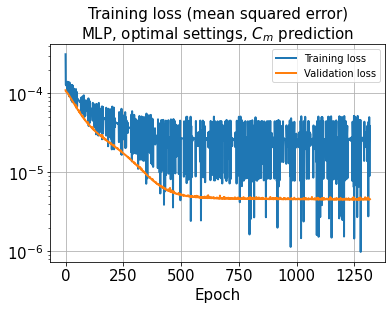

In [31]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

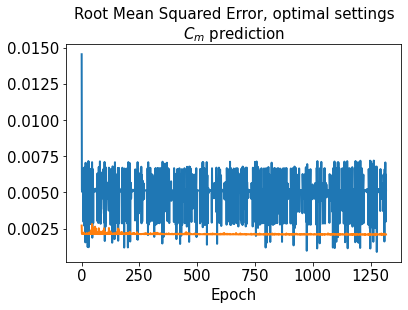

In [32]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

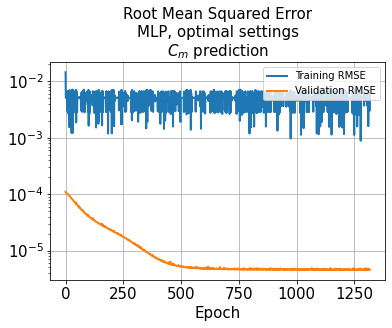

In [33]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [34]:
train_results = model.evaluate(x_train, y_train)

1750/1750 [==============================] - 6s 3ms/step - loss: 2.5996e-05 - rmse: 0.0051


In [35]:
val_results = model.evaluate(x_val, y_val)

501/501 [==============================] - 2s 3ms/step - loss: 4.5945e-06 - rmse: 0.0021


In [36]:
test_results = model.evaluate(x_test, y_test)

250/250 [==============================] - 1s 3ms/step - loss: 6.9137e-07 - rmse: 6.8835e-04


In [37]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

250/250 [==============================] - 0s 1ms/step


In [38]:
decoded_train_

array([[0.00139285],
       [0.00125794],
       [0.00138864],
       ...,
       [0.00147336],
       [0.00147425],
       [0.00154163]], dtype=float32)

In [39]:
def define_index(cm, y):
    return np.unique(np.where(np.isin(cm, y)))

In [40]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [41]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [42]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [43]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [44]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [45]:
model_directory = "D:\\TrainedModels\\20221227"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221227unsteadyValidation_MLP_Flap1_2_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_layers) +"layers_"+str(n_units)+"units_randomState50CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [46]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [47]:
os.chdir(storage_dir)

In [48]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real)*np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real+y_pred)

In [49]:
l2_error_train = l2_error(decoded_train, y_train)
mape_train = smape(decoded_train, y_train)
print(l2_error_train)
print(mape_train)

0.9854067166414876
35.81740458206814


In [50]:
l2_error_val = l2_error(decoded_val, y_val)
mape_val= smape(decoded_val, y_val)
print(l2_error_val)
print(mape_val)

0.9253223816082847
35.01055186929757


In [51]:
l2_error_test = l2_error(decoded_test, y_test)
mape_test= smape(decoded_test, y_test)
print(l2_error_test)
print(mape_test)

0.6247582177095159
33.97406446490089


In [52]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [53]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [54]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [55]:
mape_train_list = []
for i in range(0, len(x_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [56]:
mape_val_list = []
for i in range(0, len(x_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [57]:
mape_test_list = []
for i in range(0, len(x_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [58]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

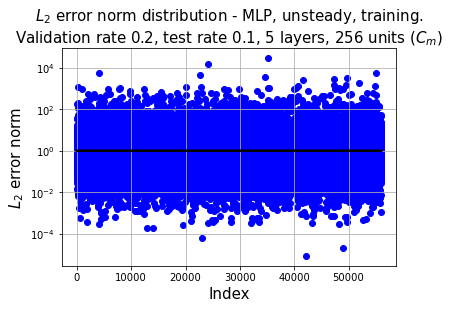

In [59]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

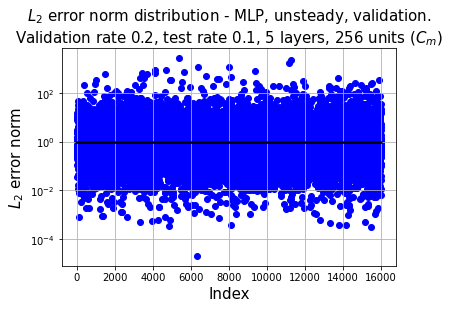

In [60]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

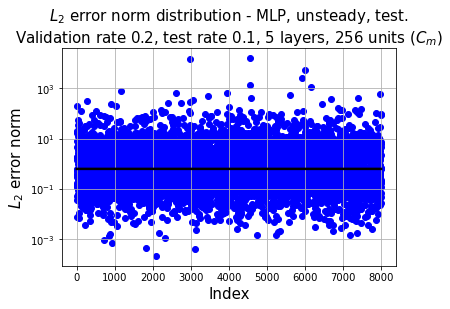

In [61]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [62]:
predicted = model.predict(x)

2500/2500 [==============================] - 4s 1ms/step


In [63]:
predicted.shape

(80000, 1)

In [64]:
tTrain = x[index_train]+10
tVal = x[index_val]+10
tTest = x[index_test]+10

In [66]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [67]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [68]:
x += 10

In [69]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tTest, iTrain, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_0_Cm
        savename1 = "CmComparison_NACA0018.jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(x[:5000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(x[:5000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    #plt.ylim([0, 0.0042])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

NACA0018 airfoil without Gurney flap
L2 error of Cm: 0.3909


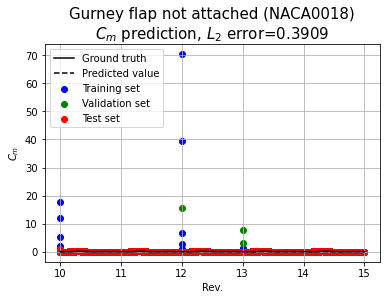

L2 error of Cm: 0.3946


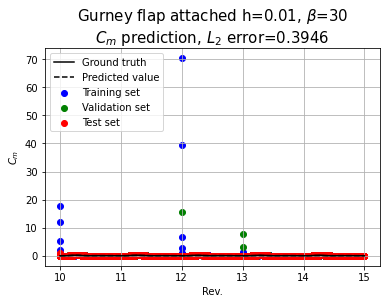

L2 error of Cm: 0.3885


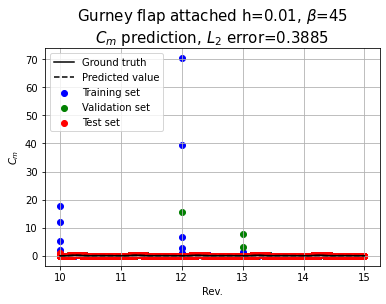

L2 error of Cm: 0.3783


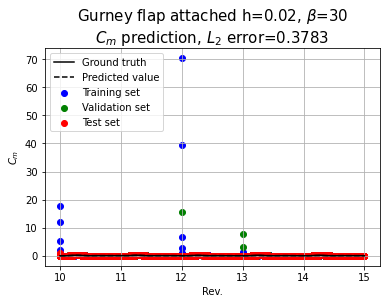

L2 error of Cm: 0.3734


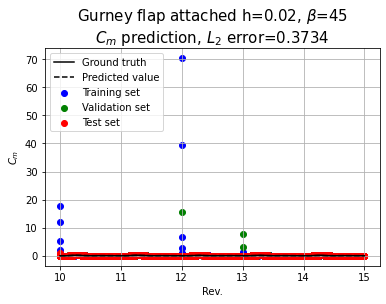

L2 error of Cm: 0.3614


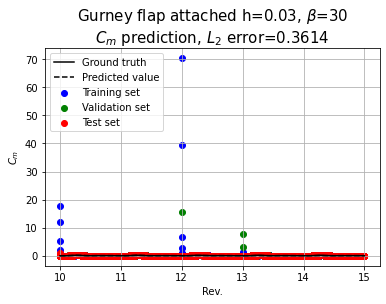

L2 error of Cm: 0.3638


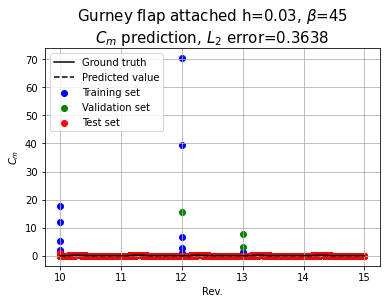

L2 error of Cm: 0.9929


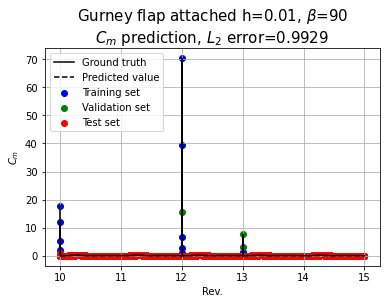

L2 error of Cm: 0.3747


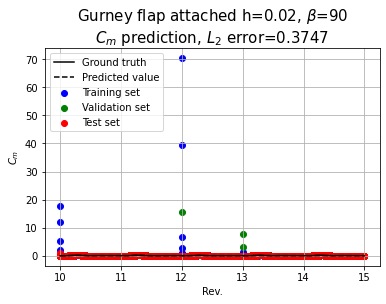

L2 error of Cm: 0.3686


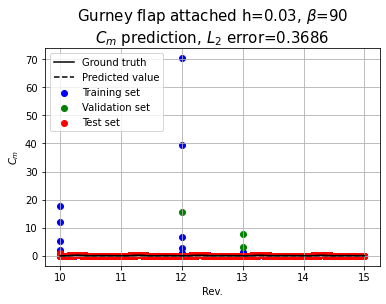

L2 error of Cm: 0.3896


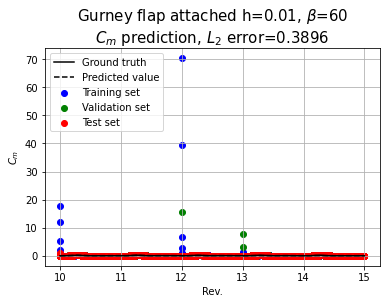

L2 error of Cm: 0.3711


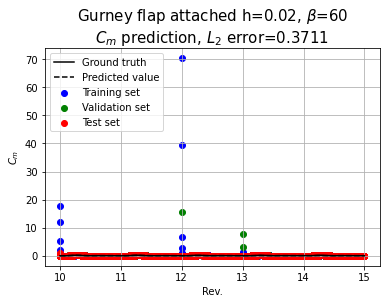

L2 error of Cm: 0.3624


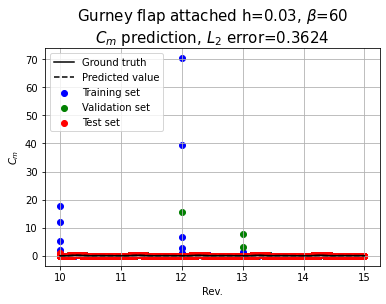

L2 error of Cm: 0.3878


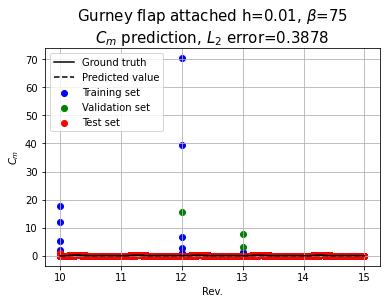

L2 error of Cm: 0.3699


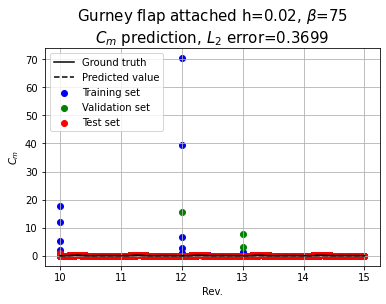

L2 error of Cm: 0.3649


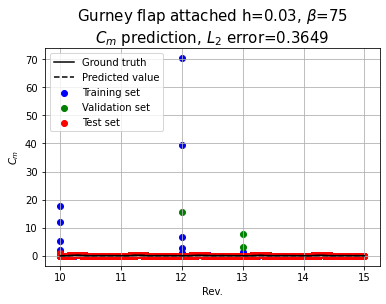

In [71]:
h = [0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03, 0.01, 0.02, 0.03]
beta = [0, 30, 45, 30, 45, 30, 45, 90, 90, 90, 60, 60, 60, 75, 75, 75]
for i in range(0,len(h)):
    # Index from each dataset
#     iTrain = []
#     iVal = []
#     iTest = []
    
#     # Index from input data (alpha, in this case)
#     t_train = []
#     t_val = []
#     t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    else:
        print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tTest, iTrain, iTest)

In [73]:
max(cm)

array([70.35399997])

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, training $L_2$ error=%.4f'%(l2_error_train)
title_Cm = title_n_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
# plt.scatter(tVal, iVal, color='g', label='Validation set')
# plt.scatter(tTest,iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, validation $L_2$ error=%.4f'%(l2_error_val)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#plt.scatter(tTest, iTest, color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [ ]:
predictedValue = predicted#[t_len*i:t_len*(i+1),:]
y_corres = y[t_len*i:t_len*(i+1),:]#[t_len*i:t_len*(i+1),:]
cm_ = predictedValue#denormalize(predictedValue)
Cm = y_corres#denormalize(y_corres)

title_0_Cm = 'Gurney flap attached h=%.2f, '%(h[1]) + r'$\beta$=%d'%(beta[1])+'\n$C_m$ prediction, test $L_2$ error=%.4f'%(l2_error_test)
title_Cm = title_0_Cm
savename1 = "CmComparison_NACA0018.jpg"

# CD graph plot
plt.plot(x, cm, 'k-', label='Ground truth')
plt.plot(x, denormalize(cm_), 'k--', label='Predicted value')
#plt.scatter(tTrain, iTrain, color='b', label='Training set')
#plt.scatter(tVal, iVal, color='g', label='Validation set')
plt.scatter(tTest, denormalize(iTest), color='r', label='Test set')
plt.xlabel('Rev.')
plt.ylabel('$C_m$')
plt.title(title_Cm, fontsize=15)        
plt.legend(loc='upper left')
#plt.ylim([0, 0.0042])
plt.grid()
#plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()